# Introduction 

Ce projet a pour but d'exploiter des données réelles pour prédire une valeur choisie.

La base de donnée a été importée via ce lien :     
https://www.kaggle.com/austinreese/craigslist-carstrucks-data

Le travail est composé de plusieurs étapes :


1.   Chargement des données
2.   Présentation/statistiques sur les données
3.   Identification des attributs non pértinents
4.   Création du pipeline
5.   Choix des attributs pour la régression
6.   Test de différents modèles de prédiction
7.   Cross Validation
8.   Conclusion










## Préparation

Vérifier que des ressources de calcul sont allouées à votre notebook est connecté (cf RAM  de disque indiqués en haut à droite) . Sinon cliquer sur le bouton connecter pour obtenir des ressources.




Pour accéder directement aux fichiers stockées sur votre google drive. Renseigner le code d'authentification lorsqu'il est demandé

Ajuster le nom de votre dossier : MyDrive/ens/bdle/dir. **Remplacer dir **

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_dir = "/content/drive/MyDrive/ens/bdle/DM2/"
os.makedirs(drive_dir, exist_ok=True)
os.listdir(drive_dir)

Mounted at /content/drive


['vehicles.csv']

Installer pyspark et findspark :


In [ ]:
!pip install -q pyspark
!pip install -q findspark

     |████████████████████████████████| 281.3 MB 43 kB/s 
     |████████████████████████████████| 198 kB 81.1 MB/s 


Démarrer la session spark

In [ ]:
import os
# !find /usr/local -name "pyspark"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"
os.environ["JAVA_HOME"] = "/usr"

In [ ]:
# Principaux import
import findspark
from pyspark.sql import SparkSession 
from pyspark import SparkConf  

# pour les dataframe et udf
from pyspark.sql import *  
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

# pour le chronomètre
import time

# initialise les variables d'environnement pour spark
findspark.init()

# Démarrage session spark 
# --------------------------
def demarrer_spark():
  local = "local[*]"
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory")
  
  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
  spark.conf.set("spark.sql.shuffle.partitions","4")    
  print("session démarrée, son id est ", sc.applicationId)
  return spark
spark = demarrer_spark()

session démarrée, son id est  local-1637525368735


In [ ]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées :  8


## Data loading

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import IndexToString
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline 
from pyspark.ml.classification import DecisionTreeClassificationModel, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
vehicles =  spark.read\
            .format("csv").option("header", "true")\
            .option("inferSchema", "true")\
            .load(drive_dir +"vehicles.csv")

In [ ]:
vehicles.printSchema()

root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: string (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: string (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (nu

In [ ]:
vehicles.show()

+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|        id|                 url|              region|          region_url|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission| VIN|drive|size|type|paint_color|image_url|description|county|state| lat|long|posting_date|
+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|7222695916|https://prescott....|            prescott|https://prescott....| 6000|null|        null| null|     null|     null|null|    null|        null|        null|null| null|null|null|       null|     null|       null|  null|  

In [ ]:
df = vehicles.withColumn("id", col("id").cast('string'))\
             .withColumn("url", col("url").cast('string'))\
             .withColumn("region", col("region").cast('string'))\
             .withColumn("region_url", col("region_url").cast('string'))\
             .withColumn("label", col("price").cast('int'))\
             .withColumn("year", col("year").cast('string'))\
             .withColumn("manufacturer", col("manufacturer").cast('string'))\
             .withColumn("model", col("model").cast('string'))\
             .withColumn("condition", col("condition").cast('string'))\
             .withColumn("cylinders", col("cylinders").cast('string'))\
             .withColumn("fuel", col("fuel").cast('string'))\
             .withColumn("odometer", col("odometer").cast('int'))\
             .withColumn("title_status", col("title_status").cast('string'))\
             .withColumn("transmission", col("transmission").cast('string'))\
             .withColumn("VIN", col("VIN").cast('string'))\
             .withColumn("drive", col("drive").cast('string'))\
             .withColumn("size", col("size").cast('string'))\
             .withColumn("type", col("type").cast('string'))\
             .withColumn("paint_color", col("paint_color").cast('string'))\
             .withColumn("image_url", col("image_url").cast('string'))\
             .withColumn("description", col("description").cast('string'))\
             .withColumn("county", col("county").cast('string'))\
             .withColumn("state", col("state").cast('string'))\
             .withColumn("lat", col("lat").cast('double'))\
             .withColumn("long", col("long").cast('double'))\
             .withColumn("posting_date", col("posting_date").cast('string'))

In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: string (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- posting_date: string (n

# Statistiques sur les données

In [ ]:
print(len(df.columns), df.count())

27 441802


On peut voir que notre dataframe est composé de 26 colonnes pour 441802 lignes.

Description des données :

In [ ]:
df.describe().show()

+-------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+-----------------+--------------------+-----------------+---------+------------------+-----------------+-----------------+------------------+-----------------+------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------+--------------------+-----------------+
|summary|                  id|                 url|              region|        region_url|               price|                year|     manufacturer|               model|        condition|cylinders|              fuel|         odometer|     title_status|      transmission|              VIN| drive|              size|              type|       paint_color|           image_url|         description|              county|               state|              lat|       long|        posting_date

Nombre de valeurs manquantes :

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+----+------+----------+-----+----+------------+-----+---------+---------+-----+--------+------------+------------+------+------+------+------+-----------+---------+-----------+------+-----+-----+-----+------------+-----+
| id| url|region|region_url|price|year|manufacturer|model|condition|cylinders| fuel|odometer|title_status|transmission|   VIN| drive|  size|  type|paint_color|image_url|description|county|state|  lat| long|posting_date|label|
+---+----+------+----------+-----+----+------------+-----+---------+---------+-----+--------+------------+------------+------+------+------+------+-----------+---------+-----------+------+-----+-----+-----+------------+-----+
|  0|9884|  6901|      6533| 6446|7890|       28937|17506|   187143|   190798|16344|   19282|       21618|       15932|174486|144178|319997|106892|     143839|    13732|      13733|382283|23077|81302|78692|       22477| 9099|
+---+----+------+----------+-----+----+------------+-----+---------+---------+-----+--------+---

Taux de valeurs manquantes :

In [ ]:
amount_missing_df = df.select([(count(when(isnan(c) | col(c).isNull(), c))/count(lit(1))).alias(c) for c in df.columns])
amount_missing_df.show()

+---+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+------------------+-----------------+------------------+-------------------+--------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+
| id|                 url|             region|         region_url|               price|               year|       manufacturer|               model|         condition|         cylinders|               fuel|           odometer|        title_status|        transmission|                VIN|             drive|             size|              type|        paint_color|           image_url|       description|            county|              state|                lat|            

# Identification des attributs non pertinents 

## Séléction du sous ensemble
On va maintenant supprimer les colonnes inutiles :

*   id, url, VIN, image_url, description, posting_date : car ce sont des attributs uniques à chaque véhicule
*   region_url, lat, long : car nous allons identifier la position avec la colonne 'region'
*   county : car c'est une colonne inutile laissée par erreur (indiqué sur kaggle)




In [ ]:
df = df.drop("id", "price", "url", "region_url","VIN","image_url","description", "county", "lat", "long", "posting_date")

In [ ]:
df.show()

+--------------------+----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+----+-----------+-----+-----+
|              region|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission|drive|size|type|paint_color|state|label|
+--------------------+----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+----+-----------+-----+-----+
|            prescott|null|        null| null|     null|     null|null|    null|        null|        null| null|null|null|       null|   az| 6000|
|        fayetteville|null|        null| null|     null|     null|null|    null|        null|        null| null|null|null|       null|   ar|11900|
|        florida keys|null|        null| null|     null|     null|null|    null|        null|        null| null|null|null|       null|   fl|21000|
|worcester / centr...|null|        null| null|     null|     null|null|    null|        null|        null| null|null|n

In [ ]:
df.printSchema()

root
 |-- region: string (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- state: string (nullable = true)
 |-- label: integer (nullable = true)



## Imputation des valeurs manquantes

In [ ]:
df = df.na.drop("any")

In [ ]:
print(len(df.columns), df.count())

16 78270


On réduit la taille du dataframe pour reduire le temps de calcul.

In [ ]:
df = df.sample(fraction=0.2)
print(len(df.columns), df.count())

16 15590


On a maintenant un dataframe que nous allons pouvoir exploiter.

# Creation du PIPELINE

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline 


'''
 |-- region: string (nullable = true)
 |--
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- 
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- state: string (nullable = true)
'''


#STRING INDEXER 

#1
#region_indexer = StringIndexer(inputCol='region',outputCol='indexed_region')

#price integer donc OK
#price: integer (nullable = true)

#2
year_indexer = StringIndexer(inputCol='year',outputCol='indexed_year')

#3
manufacturer_indexer = StringIndexer(inputCol='manufacturer',outputCol='indexed_manufacturer')

#4
model_indexer = StringIndexer(inputCol='model',outputCol='indexed_model')

#5
condition_indexer = StringIndexer(inputCol='condition',outputCol='indexed_condition')

#6
cylinders_indexer = StringIndexer(inputCol='cylinders',outputCol='indexed_cylinders')

#7
fuel_indexer = StringIndexer(inputCol='fuel',outputCol='indexed_fuel')

#Odometer integer donc ok
#odometer: integer (nullable = true)

#8
title_status_indexer = StringIndexer(inputCol='title_status',outputCol='indexed_title_status')

#9
transmission_indexer = StringIndexer(inputCol='transmission',outputCol='indexed_transmission')

#10
#drive_indexer = StringIndexer(inputCol='drive',outputCol='indexed_drive')

#11
size_indexer = StringIndexer(inputCol='size',outputCol='indexed_size')

#12
type_indexer = StringIndexer(inputCol='type',outputCol='indexed_type')

#13
paint_color_indexer = StringIndexer(inputCol='paint_color',outputCol='indexed_paint_color')

#14
#state_indexer = StringIndexer(inputCol='state',outputCol='indexed_state')

#LABEL
#label_stringIdx = StringIndexer(inputCol = 'price', outputCol = 'label')

#ONEHOTENCODER

#1
#region_onehotenc =OneHotEncoder(inputCol=region_indexer.getOutputCol(),outputCol='onehot_region')
#region_onehotenc.setDropLast(False)

#2
year_onehotenc =OneHotEncoder(inputCol=year_indexer.getOutputCol(),outputCol='onehot_year')
year_onehotenc.setDropLast(False)

#3
manufacturer_onehotenc =OneHotEncoder(inputCol=manufacturer_indexer.getOutputCol(),outputCol='onehot_manufacturer')
manufacturer_onehotenc.setDropLast(False)

#4
model_onehotenc =OneHotEncoder(inputCol=model_indexer.getOutputCol(),outputCol='onehot_model')
model_onehotenc.setDropLast(False)

#5
condition_onehotenc =OneHotEncoder(inputCol=condition_indexer.getOutputCol(),outputCol='onehot_condition')
condition_onehotenc.setDropLast(False)

#6
cylinders_onehotenc =OneHotEncoder(inputCol=cylinders_indexer.getOutputCol(),outputCol='onehot_cylinders')
cylinders_onehotenc.setDropLast(False)

#7
fuel_onehotenc =OneHotEncoder(inputCol=fuel_indexer.getOutputCol(),outputCol='onehot_fuel')
fuel_onehotenc.setDropLast(False)

#8
title_status_onehotenc =OneHotEncoder(inputCol=title_status_indexer.getOutputCol(),outputCol='onehot_title_status')
title_status_onehotenc.setDropLast(False)

#9
transmission_onehotenc =OneHotEncoder(inputCol=transmission_indexer.getOutputCol(),outputCol='onehot_transmission')
transmission_onehotenc.setDropLast(False)

#10
#drive_onehotenc =OneHotEncoder(inputCol=drive_indexer.getOutputCol(),outputCol='onehot_drive')
#drive_onehotenc.setDropLast(False)

#11
size_onehotenc =OneHotEncoder(inputCol=size_indexer.getOutputCol(),outputCol='onehot_size')
size_onehotenc.setDropLast(False)

#12
type_onehotenc =OneHotEncoder(inputCol=type_indexer.getOutputCol(),outputCol='onehot_type')
type_onehotenc.setDropLast(False)

#13
paint_color_onehotenc =OneHotEncoder(inputCol=paint_color_indexer.getOutputCol(),outputCol='onehot_paint_color')
paint_color_onehotenc.setDropLast(False)

#14
#state_onehotenc =OneHotEncoder(inputCol=state_indexer.getOutputCol(),outputCol='onehot_state')
#state_onehotenc.setDropLast(False)



#VECTOR ASSEMBLER
#'onehot_transmission'
#1
#cols = ['onehot_region','label','onehot_year','onehot_manufacturer','onehot_model','onehot_condition','onehot_cylinders','onehot_fuel','odometer','onehot_title_status','onehot_transmission','onehot_drive','onehot_size','onehot_type','onehot_paint_color','onehot_state']
cols = [ 'label','onehot_year','onehot_manufacturer','onehot_model','onehot_condition','onehot_cylinders','onehot_fuel','odometer','onehot_title_status','onehot_transmission','onehot_size','onehot_type','onehot_paint_color']
vec_assembler = VectorAssembler(inputCols= cols, outputCol= 'features_assem')

#VECTOR INDEXER

#1
vec_indexer = VectorIndexer(inputCol=vec_assembler.getOutputCol(),outputCol='features_final', maxCategories=3)

#transmission_indexer
#stages = [region_indexer,year_indexer,manufacturer_indexer,model_indexer,condition_indexer,cylinders_indexer,fuel_indexer,title_status_indexer,transmission_indexer,drive_indexer,size_indexer,type_indexer,paint_color_indexer,state_indexer,label_stringIdx,region_onehotenc,
#          year_onehotenc,manufacturer_onehotenc,model_onehotenc,condition_onehotenc,cylinders_onehotenc,fuel_onehotenc,title_status_onehotenc,transmission_onehotenc,drive_onehotenc,size_onehotenc,type_onehotenc,paint_color_onehotenc,state_onehotenc,vec_assembler,vec_indexer]

stages = [year_indexer,manufacturer_indexer,model_indexer,condition_indexer,cylinders_indexer,fuel_indexer,title_status_indexer,transmission_indexer,size_indexer,type_indexer,paint_color_indexer,
          year_onehotenc,manufacturer_onehotenc,model_onehotenc,condition_onehotenc,cylinders_onehotenc,fuel_onehotenc,title_status_onehotenc,transmission_onehotenc,size_onehotenc,type_onehotenc,paint_color_onehotenc,vec_assembler,vec_indexer]


pipeline = Pipeline(stages = stages)

lists = df.drop('region', 'drive', 'state')

train_lists = pipeline.fit(lists).transform(lists)

      


In [ ]:
train_lists.show()

+----+------------+--------------------+---------+-----------+------+--------+------------+------------+---------+-----------+-----------+-----+------------+--------------------+-------------+-----------------+-----------------+------------+--------------------+--------------------+------------+------------+-------------------+---------------+-------------------+-------------------+----------------+----------------+-------------+-------------------+-------------------+-------------+--------------+------------------+--------------------+--------------------+
|year|manufacturer|               model|condition|  cylinders|  fuel|odometer|title_status|transmission|     size|       type|paint_color|label|indexed_year|indexed_manufacturer|indexed_model|indexed_condition|indexed_cylinders|indexed_fuel|indexed_title_status|indexed_transmission|indexed_size|indexed_type|indexed_paint_color|    onehot_year|onehot_manufacturer|       onehot_model|onehot_condition|onehot_cylinders|  onehot_fuel|one

# Préparation du Dataframe

On va maintenant préparer le dataframe en supprimant les valeurs aberrantes, puis choisir les colonnes que l'on va utiliser pour la prédiction.

In [ ]:
test = train_lists.select(col('label')).groupBy(col('label')).count().orderBy(col('count').desc())
test.show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  688|
| 6500|  208|
| 4500|  197|
| 3500|  194|
| 7500|  187|
| 5500|  167|
| 2500|  154|
|    1|  152|
| 6995|  151|
| 8500|  145|
| 5000|  140|
| 5995|  136|
| 7995|  130|
| 4000|  127|
| 6000|  124|
| 4995|  122|
| 9995|  121|
| 3000|  116|
| 9500|  116|
| 8995|  116|
+-----+-----+
only showing top 20 rows



Beaucoup de prix à 0 ou 1, et de valeurs unique.
On va supprimer ces lignes.

In [ ]:
test = test.where(col('label')>1).where(col('count')!=1)

Statistiques sur le label (price) :

In [ ]:

test.select("label").describe().show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|              1023|
|   mean|18861.648093841643|
| stddev|16055.805037324937|
|    min|                 6|
|    max|            123456|
+-------+------------------+



Application des modifications sur la liste de train :

In [ ]:
train_lists = train_lists.where(col('label')>1)

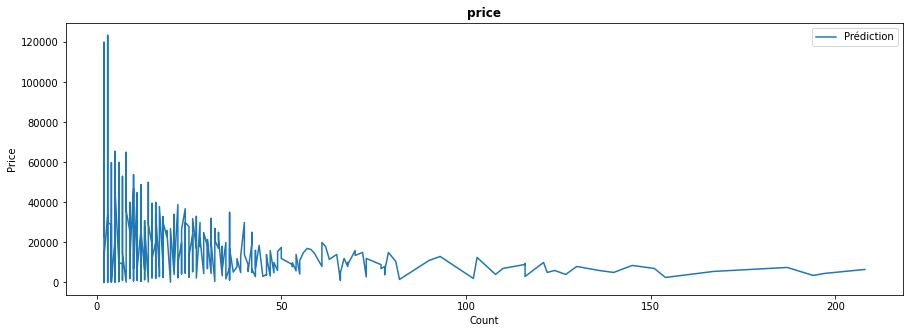

In [ ]:
import matplotlib.pyplot as plt

yhat = test.select("label").collect()
xhat = test.select("count").collect()

# Plots
nb_points = 2000
plt.figure(figsize=(15,5))
plt.title("price", fontweight='bold')
plt.xlabel("Count")
plt.ylabel('Price')
plt.plot(xhat[:nb_points], yhat[:nb_points], label='Prédiction')
plt.legend()
plt.show()

Pour prédire le prix, nous allons utiliser les colonnes suivantes :

year, manufacturer, odometer, model, condition, cylinders, fuel, title_status, transmission, size, type, paint_color.

Il faut à présent regarder si les valeurs de ces colonnes sont exploitables :

Paint_color :

In [ ]:
test_paint_color = train_lists.select(col('indexed_paint_color')).groupBy(col('indexed_paint_color')).count().orderBy(col('count').desc())
test_paint_color.select("indexed_paint_color").describe().show()

+-------+-------------------+
|summary|indexed_paint_color|
+-------+-------------------+
|  count|                 12|
|   mean|                5.5|
| stddev|  3.605551275463989|
|    min|                0.0|
|    max|               11.0|
+-------+-------------------+



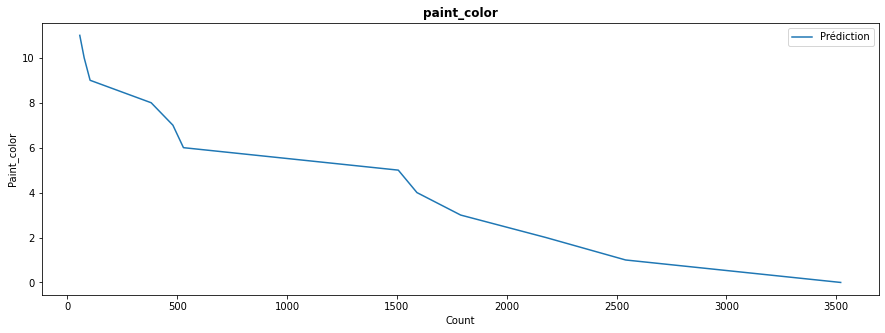

In [ ]:
import matplotlib.pyplot as plt

yhat = test_paint_color.select("indexed_paint_color").collect()
xhat = test_paint_color.select("count").collect()

# Plots
nb_points = 2000
plt.figure(figsize=(15,5))
plt.title("paint_color", fontweight='bold')
plt.xlabel("Count")
plt.ylabel('Paint_color')
plt.plot(xhat[:nb_points], yhat[:nb_points], label='Prédiction')
plt.legend()
plt.show()

Type :

In [ ]:
test_type = train_lists.select(col('indexed_type')).groupBy(col('indexed_type')).count().orderBy(col('count').desc())
test_type.select("indexed_type").describe().show()

+-------+------------------+
|summary|      indexed_type|
+-------+------------------+
|  count|                13|
|   mean|               6.0|
| stddev|3.8944404818493075|
|    min|               0.0|
|    max|              12.0|
+-------+------------------+



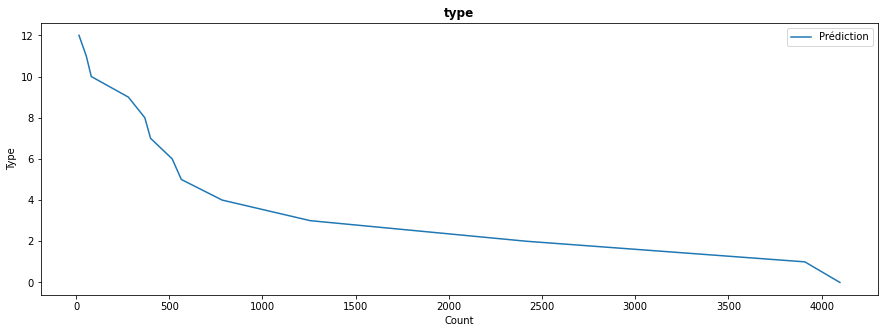

In [ ]:
import matplotlib.pyplot as plt

yhat = test_type.select("indexed_type").collect()
xhat = test_type.select("count").collect()

# Plots
nb_points = 2000
plt.figure(figsize=(15,5))
plt.title("type", fontweight='bold')
plt.xlabel("Count")
plt.ylabel('Type')
plt.plot(xhat[:nb_points], yhat[:nb_points], label='Prédiction')
plt.legend()
plt.show()

Size :

In [ ]:
test_size = train_lists.select(col('indexed_size')).groupBy(col('indexed_size')).count().orderBy(col('count').desc())
test_size.select("indexed_size").describe().show()

+-------+------------------+
|summary|      indexed_size|
+-------+------------------+
|  count|                 4|
|   mean|               1.5|
| stddev|1.2909944487358056|
|    min|               0.0|
|    max|               3.0|
+-------+------------------+



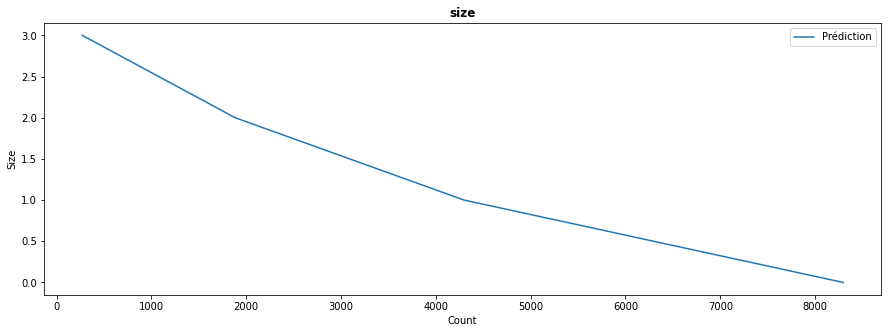

In [ ]:
import matplotlib.pyplot as plt

yhat = test_size.select("indexed_size").collect()
xhat = test_size.select("count").collect()

# Plots
nb_points = 2000
plt.figure(figsize=(15,5))
plt.title("size", fontweight='bold')
plt.xlabel("Count")
plt.ylabel('Size')
plt.plot(xhat[:nb_points], yhat[:nb_points], label='Prédiction')
plt.legend()
plt.show()

Transmission :

In [ ]:
test_transmission = train_lists.select(col('indexed_transmission')).groupBy(col('indexed_transmission')).count().orderBy(col('count').desc())
test_transmission.select("indexed_transmission").describe().show()

+-------+--------------------+
|summary|indexed_transmission|
+-------+--------------------+
|  count|                   3|
|   mean|                 1.0|
| stddev|                 1.0|
|    min|                 0.0|
|    max|                 2.0|
+-------+--------------------+



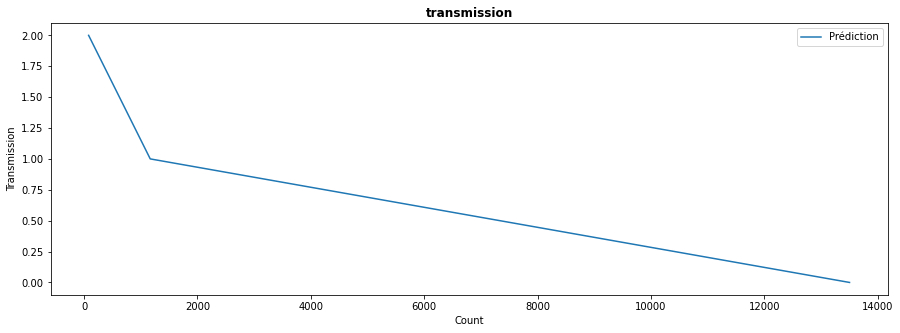

In [ ]:
import matplotlib.pyplot as plt

yhat = test_transmission.select("indexed_transmission").collect()
xhat = test_transmission.select("count").collect()

# Plots
nb_points = 2000
plt.figure(figsize=(15,5))
plt.title("transmission", fontweight='bold')
plt.xlabel("Count")
plt.ylabel('Transmission')
plt.plot(xhat[:nb_points], yhat[:nb_points], label='Prédiction')
plt.legend()
plt.show()

Title_status :

In [ ]:
test_title_status = train_lists.select(col('indexed_title_status')).groupBy(col('indexed_title_status')).count().orderBy(col('count').desc())
test_title_status.select("indexed_title_status").describe().show()

+-------+--------------------+
|summary|indexed_title_status|
+-------+--------------------+
|  count|                   6|
|   mean|                 2.5|
| stddev|  1.8708286933869707|
|    min|                 0.0|
|    max|                 5.0|
+-------+--------------------+



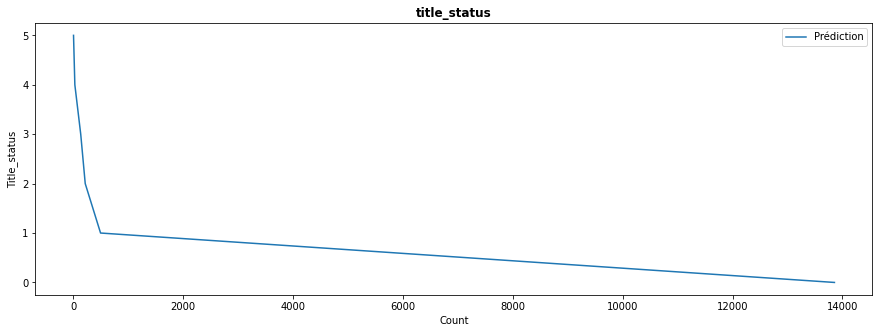

In [ ]:
import matplotlib.pyplot as plt

yhat = test_title_status.select("indexed_title_status").collect()
xhat = test_title_status.select("count").collect()

# Plots
nb_points = 2000
plt.figure(figsize=(15,5))
plt.title("title_status", fontweight='bold')
plt.xlabel("Count")
plt.ylabel('Title_status')
plt.plot(xhat[:nb_points], yhat[:nb_points], label='Prédiction')
plt.legend()
plt.show()

Fuel :

In [ ]:
test_fuel = train_lists.select(col('indexed_fuel')).groupBy(col('indexed_fuel')).count().orderBy(col('count').desc())
test_fuel.select("indexed_fuel").describe().show()

+-------+------------------+
|summary|      indexed_fuel|
+-------+------------------+
|  count|                 5|
|   mean|               2.0|
| stddev|1.5811388300841898|
|    min|               0.0|
|    max|               4.0|
+-------+------------------+



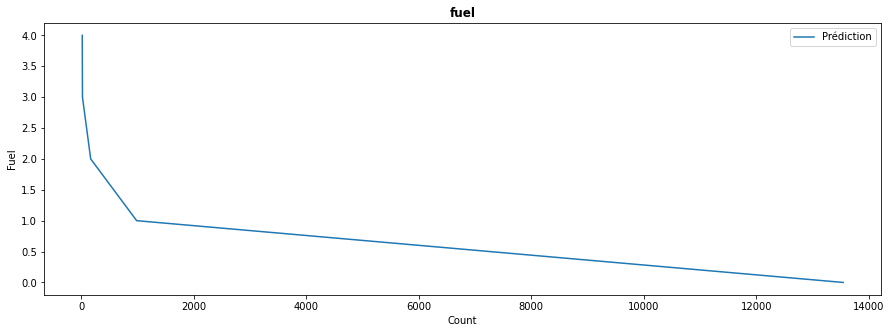

In [ ]:
import matplotlib.pyplot as plt

yhat = test_fuel.select("indexed_fuel").collect()
xhat = test_fuel.select("count").collect()

# Plots
nb_points = 2000
plt.figure(figsize=(15,5))
plt.title("fuel", fontweight='bold')
plt.xlabel("Count")
plt.ylabel('Fuel')
plt.plot(xhat[:nb_points], yhat[:nb_points], label='Prédiction')
plt.legend()
plt.show()

Cylinders :

In [ ]:
test_cylinders = train_lists.select(col('indexed_cylinders')).groupBy(col('indexed_cylinders')).count().orderBy(col('count').desc())
test_cylinders.select("indexed_cylinders").describe().show()

+-------+-----------------+
|summary|indexed_cylinders|
+-------+-----------------+
|  count|                8|
|   mean|              3.5|
| stddev|2.449489742783178|
|    min|              0.0|
|    max|              7.0|
+-------+-----------------+



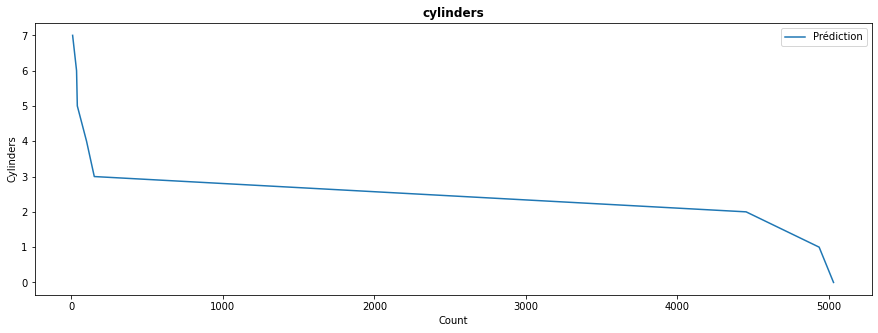

In [ ]:
import matplotlib.pyplot as plt

yhat = test_cylinders.select("indexed_cylinders").collect()
xhat = test_cylinders.select("count").collect()

# Plots
nb_points = 2000
plt.figure(figsize=(15,5))
plt.title("cylinders", fontweight='bold')
plt.xlabel("Count")
plt.ylabel('Cylinders')
plt.plot(xhat[:nb_points], yhat[:nb_points], label='Prédiction')
plt.legend()
plt.show()

Condition :

In [ ]:
test_condition = train_lists.select(col('indexed_condition')).groupBy(col('indexed_condition')).count().orderBy(col('count').desc())
test_condition.select("indexed_condition").describe().show()

+-------+------------------+
|summary| indexed_condition|
+-------+------------------+
|  count|                 6|
|   mean|               2.5|
| stddev|1.8708286933869707|
|    min|               0.0|
|    max|               5.0|
+-------+------------------+



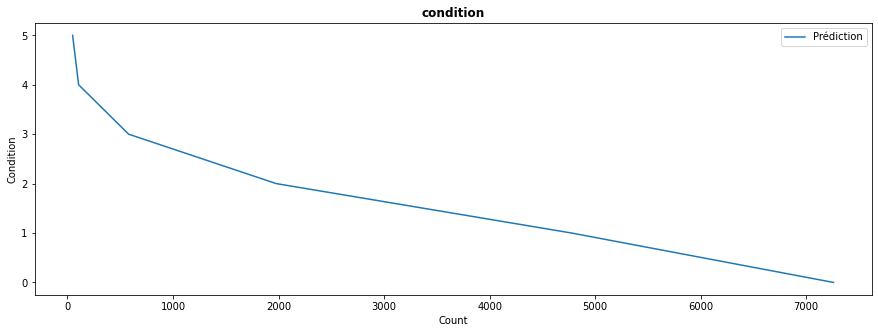

In [ ]:
import matplotlib.pyplot as plt

yhat = test_condition.select("indexed_condition").collect()
xhat = test_condition.select("count").collect()

# Plots
nb_points = 2000
plt.figure(figsize=(15,5))
plt.title("condition", fontweight='bold')
plt.xlabel("Count")
plt.ylabel('Condition')
plt.plot(xhat[:nb_points], yhat[:nb_points], label='Prédiction')
plt.legend()
plt.show()

Year :

In [ ]:
test_year = train_lists.select(col('indexed_year')).groupBy(col('indexed_year')).count().orderBy(col('count').desc())

In [ ]:
test_year.select("indexed_year").describe().show()

+-------+------------------+
|summary|      indexed_year|
+-------+------------------+
|  count|                92|
|   mean|              45.5|
| stddev|26.702059845637375|
|    min|               0.0|
|    max|              91.0|
+-------+------------------+



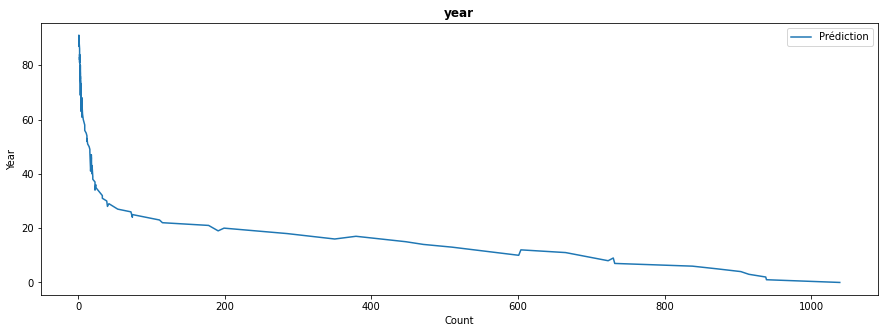

In [ ]:
import matplotlib.pyplot as plt

yhat = test_year.select("indexed_year").collect()
xhat = test_year.select("count").collect()

# Plots
nb_points = 2000
plt.figure(figsize=(15,5))
plt.title("year", fontweight='bold')
plt.xlabel("Count")
plt.ylabel('Year')
plt.plot(xhat[:nb_points], yhat[:nb_points], label='Prédiction')
plt.legend()
plt.show()

Manufacturer :

In [ ]:
test_manufacturer = train_lists.select(col('indexed_manufacturer')).groupBy(col('indexed_manufacturer')).count().orderBy(col('count').desc())
test_manufacturer.select("indexed_manufacturer").describe().show()

+-------+--------------------+
|summary|indexed_manufacturer|
+-------+--------------------+
|  count|                  41|
|   mean|                20.0|
| stddev|  11.979148550710939|
|    min|                 0.0|
|    max|                40.0|
+-------+--------------------+



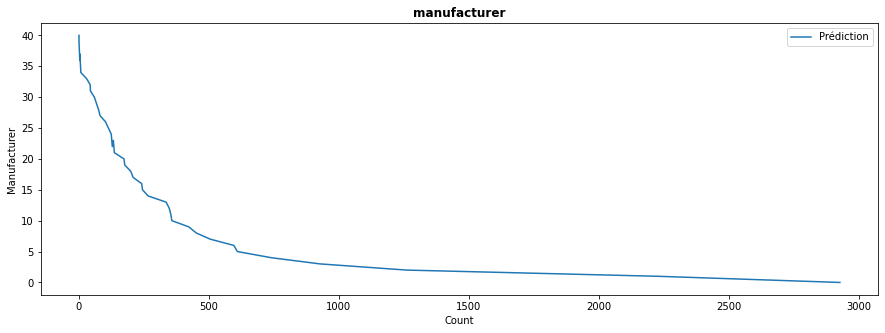

In [ ]:
import matplotlib.pyplot as plt

yhat = test_manufacturer.select("indexed_manufacturer").collect()
xhat = test_manufacturer.select("count").collect()

# Plots
nb_points = 2000
plt.figure(figsize=(15,5))
plt.title("manufacturer", fontweight='bold')
plt.xlabel("Count")
plt.ylabel('Manufacturer')
plt.plot(xhat[:nb_points], yhat[:nb_points], label='Prédiction')
plt.legend()
plt.show()

Odometer :

In [ ]:
test_odometer = train_lists.select(col('odometer')).groupBy(col('odometer')).count().orderBy(col('count').desc())
test_odometer.select("odometer").describe().show()

+-------+------------------+
|summary|          odometer|
+-------+------------------+
|  count|              7621|
|   mean|121919.52867077812|
| stddev|227664.95384370655|
|    min|                 0|
|    max|          10000000|
+-------+------------------+



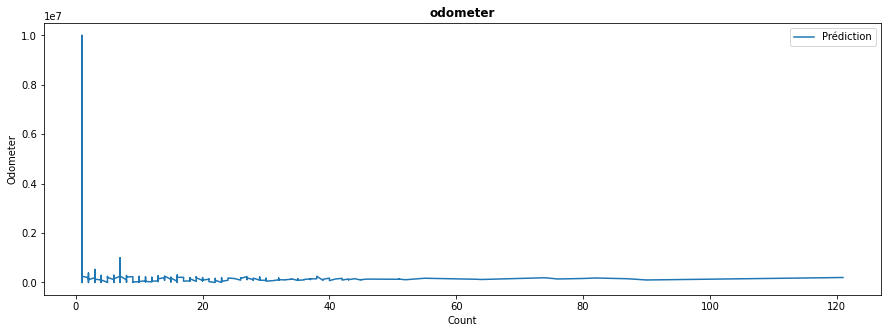

In [ ]:
import matplotlib.pyplot as plt

yhat = test_odometer.select("odometer").collect()
xhat = test_odometer.select("count").collect()

# Plots
nb_points = 2000
plt.figure(figsize=(15,5))
plt.title("odometer", fontweight='bold')
plt.xlabel("Count")
plt.ylabel('Odometer')
plt.plot(xhat[:nb_points], yhat[:nb_points], label='Prédiction')
plt.legend()
plt.show()

Model :

In [ ]:
test_model = train_lists.select(col('indexed_model')).groupBy(col('indexed_model')).count().orderBy(col('count').desc())
test_model.select("indexed_model").describe().show()

+-------+------------------+
|summary|     indexed_model|
+-------+------------------+
|  count|              3785|
|   mean|1931.5270805812418|
| stddev|1127.5966103228527|
|    min|               0.0|
|    max|            3904.0|
+-------+------------------+



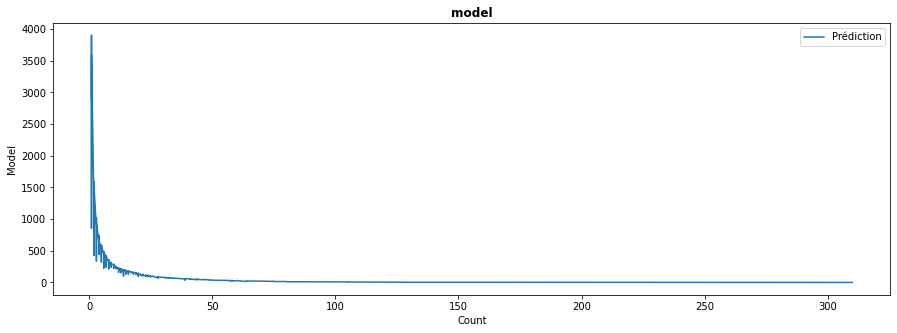

In [ ]:
import matplotlib.pyplot as plt

yhat = test_model.select("indexed_model").collect()
xhat = test_model.select("count").collect()

# Plots
nb_points = 2000
plt.figure(figsize=(15,5))
plt.title("model", fontweight='bold')
plt.xlabel("Count")
plt.ylabel('Model')
plt.plot(xhat[:nb_points], yhat[:nb_points], label='Prédiction')
plt.legend()
plt.show()

Nous avons pu voir que les données sélectionnées sont exploitables :

In [ ]:
train_lists_norm = train_lists.drop('region', 'indexed_region', 'onehot_region', 'drive', 'indexed_drive', 'onehot_drive', 'state', 'indexed_state', 'onehot_state' )

In [ ]:
train_lists.show()

+----+------------+--------------------+---------+-----------+------+--------+------------+------------+---------+-----------+-----------+-----+------------+--------------------+-------------+-----------------+-----------------+------------+--------------------+--------------------+------------+------------+-------------------+---------------+-------------------+-------------------+----------------+----------------+-------------+-------------------+-------------------+-------------+--------------+------------------+--------------------+--------------------+
|year|manufacturer|               model|condition|  cylinders|  fuel|odometer|title_status|transmission|     size|       type|paint_color|label|indexed_year|indexed_manufacturer|indexed_model|indexed_condition|indexed_cylinders|indexed_fuel|indexed_title_status|indexed_transmission|indexed_size|indexed_type|indexed_paint_color|    onehot_year|onehot_manufacturer|       onehot_model|onehot_condition|onehot_cylinders|  onehot_fuel|one

# Test de différents modèles de prédiction.

In [ ]:
(trainingData, testData) = train_lists_norm.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 10289
Test Dataset Count: 4461


## Application de modèles :

DecisionTreeRegressor :

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features_assem', labelCol = 'label')
dt_model = dt.fit(trainingData)
dt_predictions = dt_model.transform(testData)

dt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

dt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mae")
mae = dt_evaluator.evaluate(dt_predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

Root Mean Squared Error (RMSE) on test data = 1.84667e+06
Mean Absolute Error (MAE) on test data = 28308.1


LinearRegression :

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol ='features_assem', labelCol = 'label')
lr_model = lr.fit(trainingData)
lr_predictions = lr_model.transform(testData)

lr_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

lr_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mae")
mae = lr_evaluator.evaluate(dt_predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

Root Mean Squared Error (RMSE) on test data = 218.559
Mean Absolute Error (MAE) on test data = 28308.1


RandomForestRegressor :

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol ='features_assem', labelCol = 'label')
rf_model = rf.fit(trainingData)
rf_predictions = rf_model.transform(testData)

rf_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rf_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mae")
mae = rf_evaluator.evaluate(dt_predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

Root Mean Squared Error (RMSE) on test data = 1.84785e+06
Mean Absolute Error (MAE) on test data = 28308.1


GBTRegressor :

In [ ]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol ='features_assem', labelCol = 'label')
gbt_model = gbt.fit(trainingData)
gbt_predictions = gbt_model.transform(testData)

gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mae")
mae = gbt_evaluator.evaluate(dt_predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

Root Mean Squared Error (RMSE) on test data = 1.84644e+06
Mean Absolute Error (MAE) on test data = 28308.1


## Cross Validation sur les modèles :

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder().build())
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=dt_evaluator, numFolds=3)

cvModel = cv.fit(trainingData)
predictions = cvModel.transform(testData)
dt_evaluator.evaluate(predictions)

28308.088370531368

In [ ]:
paramGrid = (ParamGridBuilder().build())
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=lr_evaluator, numFolds=3)

cvModel = cv.fit(trainingData)
predictions = cvModel.transform(testData)
lr_evaluator.evaluate(predictions)

8.507243048608714

In [ ]:
paramGrid = (ParamGridBuilder().build())
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=rf_evaluator, numFolds=3)

cvModel = cv.fit(trainingData)
predictions = cvModel.transform(testData)
rf_evaluator.evaluate(predictions)

29984.583247890656

In [ ]:
paramGrid = (ParamGridBuilder().build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=gbt_evaluator, numFolds=3)

cvModel = cv.fit(trainingData)
predictions = cvModel.transform(testData)
gbt_evaluator.evaluate(predictions)

28314.921824989917

In [ ]:
train_lists.select('label').describe().show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|             14750|
|   mean|22088.493491525423|
| stddev|1016489.1013603178|
|    min|                 5|
|    max|         123456789|
+-------+------------------+



# Conclusion

En comparant les valeurs des métriques et de la cross validation des différents modéles de prédictions, avec la moyenne et l'écart type de la liste des prix des voitures, nous pouvons dire que le meilleur modèle de prédiction est le LinearRegression dans notre cas.


La précision de nos prédiction est également due au choix des features que nous avons sélectionnés. Cependant, d'autres combinaisons auraient été possibles. 
